In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

from svd import ApproxSVD

In [2]:
def load_mnist_subset(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32).to_numpy() / 255.0
    X = X.T[:, :n_samples]  # (784, n_samples)
    
    return X

In [3]:
def load_mnist_combined_subset(n_samples=5000):
    # Load MNIST digits
    mnist_digits = fetch_openml('mnist_784', version=1, as_frame=False)
    X_digits = mnist_digits.data.astype(np.float32).T[:, :n_samples] / 255.0  # Shape: (784, n_samples)

    # Load Fashion-MNIST
    fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X_fashion = fashion_mnist.data.astype(np.float32).T[:, :n_samples] / 255.0  # Shape: (784, n_samples)

    # Concatenate both datasets along columns
    X_combined = np.hstack((X_digits, X_fashion))  # Shape: (784, 2 * n_samples)

    return X_combined

In [4]:
def show_reconstruction(X_orig, X_recon, num_images=10):
    plt.figure(figsize=(num_images, 2))
    
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_orig[:, i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(X_recon[:, i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

In [5]:
def explained_variance_ratio(X, X_reconstructed):
    error = np.linalg.norm(X - X_reconstructed, 'fro')**2
    total = np.linalg.norm(X, 'fro')**2
    
    return 1 - error / total

In [ ]:
def run_approx_svd_experiment(input_data, p=50, g=200):
    X = input_data

    approx_svd = ApproxSVD(n_iter = g, 
                           p = p, 
                           score_method = 'cf', 
                           debug_mode = True,
                           jobs = 10,
                           stored_g = False,
                           use_shared_memory=True,
                           use_heap = False)
    traces, U, X_approx = approx_svd.fit_batched(X)

    X_reduced = U.T[:p, :] @ X              # (p x d) @ (d x n) = (p x n)
    X_reconstructed = U[:, :p] @ X_reduced  # (d x p) @ (p x n) = (d x n)

    error = np.linalg.norm(X - X_reconstructed, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    explained_variance_ratio = 1 - (error / total)
    print(f"Explained Variance: {explained_variance_ratio * 100:.2f}%")

    show_reconstruction(X, X_reconstructed)

In [7]:
mnist_np = load_mnist_subset(n_samples=2200)

INFO - Batch size too small! Setting to 784
DEBUG - Time: 7.200 seconds for initial scores
100%|██████████| 20/20 [00:00<00:00, 102.85it/s]
DEBUG - Time: 7.393 seconds for total time
DEBUG - Time: 9.030 seconds for initial scores
100%|██████████| 20/20 [00:00<00:00, 106.82it/s]
DEBUG - Time: 9.222 seconds for total time
DEBUG - Time: 7.889 seconds for initial scores
100%|██████████| 20/20 [00:00<00:00, 109.28it/s]
DEBUG - Time: 8.068 seconds for total time


Explained Variance: 12.21%


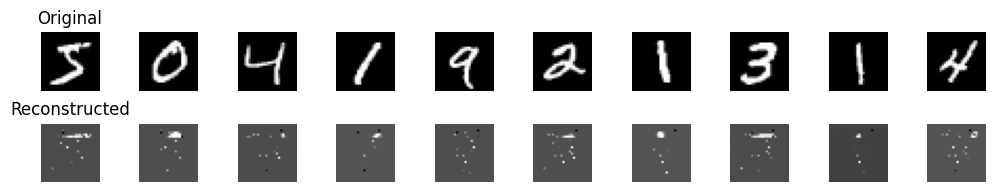

In [8]:
run_approx_svd_experiment(mnist_np, p=200, g=20)

INFO - Batch size too small! Setting to 784
DEBUG - Time: 6.001 seconds for initial scores
100%|██████████| 200/200 [00:02<00:00, 84.85it/s]
DEBUG - Time: 8.349 seconds for total time
DEBUG - Time: 7.371 seconds for initial scores
100%|██████████| 200/200 [00:02<00:00, 93.67it/s]
DEBUG - Time: 9.506 seconds for total time
DEBUG - Time: 6.288 seconds for initial scores
100%|██████████| 200/200 [00:02<00:00, 92.18it/s]
DEBUG - Time: 8.449 seconds for total time


Explained Variance: 27.12%


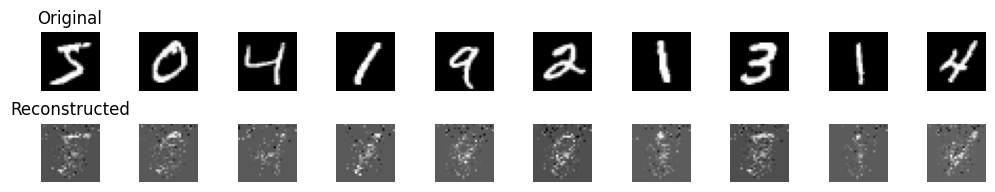

In [8]:
run_approx_svd_experiment(mnist_np, p=200, g=200)

In [ ]:
# this does 45% with formula
run_approx_svd_experiment(mnist_np, p=200, g=2000)

In [ ]:
run_approx_svd_experiment(mnist_np, p=200, g=20000)

In [ ]:
run_approx_svd_experiment(mnist_np, p=50, g=20000)

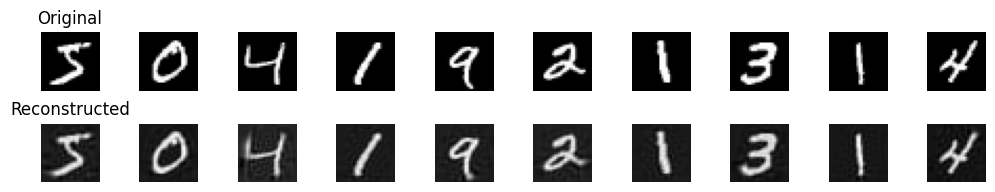

In [13]:
from sklearn.decomposition import IncrementalPCA, PCA

X = mnist_np.T  # Shape: (n_samples, 784)

transformer = IncrementalPCA(n_components=200, batch_size=201)
X_transformed = transformer.fit_transform(X)            # Shape: (n_samples, 200)
X_recon = transformer.inverse_transform(X_transformed)  # Shape: (n_samples, 784)

show_reconstruction(X.T, X_recon.T)